In [441]:
### Importing and transforming dates to integers

from scipy import stats
import matplotlib.pyplot as plt
import pystan
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn
import math


data = pd.read_csv('data.csv')

In [442]:
#Add a 't' column for days since the first measurement

array = data['Date'].to_numpy()
new_dates = []
for d in array:
    new_dates.append(datetime.strptime(d, "%m/%d/%Y"))

days_passed = [0]
delta = 0
for i in range(1,len(new_dates)):
    delta += (new_dates[i]-new_dates[i-1]).days
    days_passed.append(delta)

data['t']=days_passed
data['n']=np.arange(len(data['t']))
data

,Date,CO2,t,n
0,3/29/1958,316.19,0,0
1,4/5/1958,317.31,7,1
2,4/12/1958,317.69,14,2
3,4/19/1958,317.58,21,3
4,4/26/1958,316.48,28,4
...,...,...,...,...
3134,8/31/2019,409.32,22435,3134
3135,9/7/2019,408.80,22442,3135
3136,9/14/2019,408.61,22449,3136
3137,9/21/2019,408.50,22456,3137


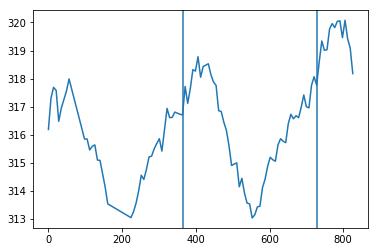

In [443]:
#visualize some of the data

t = data['t'].to_numpy()
y = data['CO2'].to_numpy()
n = data['n'].to_numpy()

# 0 is in March
plt.plot(t[0:100],y[:100])
plt.axvline(x=365)
plt.axvline(x=365*2)
plt.show()

In [ ]:
# A cell to examine priors and produce their plots

#X2 = np.linspace(0,0.1,200)
#plt.plot(X2,stats.gamma(a=1,scale=0.01).pdf(X2), label = '$Gamma(\\alpha=4, \\beta=2$)')
#plt.title('Prior over Quad')
#plt.show()

In [425]:
# Playing with periodic functions to see if this form makes some sense

def f(x, A=1, lambd=2, phi=0, sigma=0.3):
    return (
        307 + 0.004* x + 0.0000004 * x**2 + A * np.cos(lambd * math.pi * x/365.25+phi) +
        stats.norm.rvs(0, sigma, size=np.shape(x)))

def f_post(x, c0=314, c1=0.0022, c2=2.64, c3=0.00076, c4=0.223, quad=0.00000008, inner=-0.25):
    return (
        c0+c1*x+quad*x**2+c2*np.cos((2*math.pi*x/365.25+c3)+inner*np.cos(2*math.pi*x/365.25+c3))+
        stats.norm.rvs(0, c4, size=np.shape(x)))

#plot_x = t[1000:1100]
#plt.plot(plot_x, f_post(plot_x))
#plt.axvline(x=365)
#plt.axvline(x=365*2)
#plt.title('A toy periodic function')
#plt.show()

## The Example Model

In [431]:
#Stan model: the example model

stan_code = """
data {
    int<lower=0> n;        // The number of data
    int<lower=0> future_n; // Predicted data length
    int future_t[future_n]; // days for predictions
    real y[n];             // The co2 data
    real t[n];             // times
}

parameters {
    real c0;
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c3;
    real<lower=0> c4;
}


model {
    c0 ~ normal(306, 5);
    c1 ~ gamma(1, 0.1); // assuming there is no way the trend is negative
    c2 ~ gamma(2.5, 3);
    c3 ~ gamma(2.5, 3);
    c4 ~ gamma(1, 0.3);

    for(i in 1:n) {
        y[i] ~ normal(
            c0 + t[i] * c1 + c2 * cos(2 * pi() * t[i] / 365.25 + c3),
            c4);
    }
}

generated quantities {
    real future_x[future_n];
    for(i in 1:future_n) {
        future_x[i] = normal_rng(
            c0 + c1 * future_t[i] + c2 * cos(2 * pi() * future_t[i] / 365.25 + c3),
            c4);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cbf5b97d765120a3bc20177a76e07573 NOW.


## Quad Model

In [426]:
#Stan model: the example model + a quadradic term

stan_code_quad = """
data {
    int<lower=0> n;        // The number of data
    int<lower=0> future_n; // Predicted data length
    int future_t[future_n]; // days for predictions
    real y[n];             // The co2 data
    real t[n];             // times
}

parameters {
    real c0;
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c3;
    real<lower=0> c4;
    real<lower=0> quad;
}


model {
    c0 ~ normal(306, 5);
    c1 ~ gamma(1, 0.1); // assuming there is no way the trend is negative
    c2 ~ gamma(2.5, 3);
    c3 ~ gamma(2.5, 3);
    c4 ~ gamma(1, 0.3);
    quad ~ gamma(1, 0.01); // assuming there is no way the trend is negative

    for(i in 1:n) {
        y[i] ~ normal(
            c0 + c1*t[i] + quad*pow(t[i],2) + c2*cos(2 * pi() * t[i] / 365.25 + c3),
            c4);
    }
}

generated quantities {
    real future_x[future_n];
    for(i in 1:future_n) {
        future_x[i] = normal_rng(
            c0 + c1 * future_t[i] + quad*pow(future_t[i],2) + c2*cos(2*pi()*future_t[i]/365.25 + c3),
            c4);
    }
}
"""

stan_model_quad = pystan.StanModel(model_code=stan_code_quad)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_621a9fb7cd55d1b4817db1a3fc2faafe NOW.


## Inner cosine

In [432]:
#Stan model: inner cosine

stan_code_inner = """
data {
    int<lower=0> n;        // The number of data
    int<lower=0> future_n; // Predicted data length
    int future_t[future_n]; // days for predictions
    real y[n];             // The co2 data
    real t[n];             // times
}

parameters {
    real c0;
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c3;
    real<lower=0> c4;
    real<lower=0> quad;
    real<lower=-3,upper=3> inner; // VISUALLY DICTATED BOUNDARIES
}


model {
    c0 ~ normal(306, 5);
    c1 ~ gamma(1, 0.1); // assuming there is no way the trend is negative
    c2 ~ gamma(2.5, 3);
    c3 ~ gamma(2.5, 3);
    c4 ~ gamma(1, 0.3);
    inner ~ normal(0,1); // 95% between -2 and 2
    quad ~ gamma(1, 0.01); // assuming there is no way the trend is negative

    for(i in 1:n) {
        y[i] ~ normal(
            c0 + c1*t[i] + quad*pow(t[i],2) + 
            c2*cos((2 * pi() * t[i] / 365.25 + c3)+inner*cos(2 * pi() * t[i] / 365.25 + c3)),
            c4);
    }
}

generated quantities {
    real future_x[future_n];
    for(i in 1:future_n) {
        future_x[i] = normal_rng(
            c0 + c1 * future_t[i] + quad*pow(future_t[i],2) + 
            c2*cos((2*pi()*future_t[i] / 365.25 + c3)+inner*cos(2 * pi() * future_t[i] / 365.25 + c3)),
            c4);
    }
}
"""

stan_model_inner = pystan.StanModel(model_code=stan_code_inner)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66dfc2962fb0600241ac28e7c5e1d6c5 NOW.


In [436]:
# Run and print results from the three models
 
n = len(t)-len(t)//10 #training data - 90%
future_t = t[n:] # the other 10%

stan_data = {
    'n': len(y[:n]),
    'y': y[:n],
    't': t[:n],
    'future_t': future_t, 
    'future_n': len(future_t)} 

parameters = ['c0', 'c1', 'c2', 'c3', 'c4']
#parameters = ['c0', 'c1', 'c2', 'c3', 'c4', 'quad']
#parameters = ['c0', 'c1', 'c2', 'c3', 'c4', 'quad', 'inner']

example_results = stan_model.sampling(data=stan_data)
#quad_results = stan_model_quad.sampling(data=stan_data)
#inner_results = stan_model_inner.sampling(data=stan_data)

print(example_results.stansummary(pars=parameters))
#print(quad_results.stansummary(pars=parameters))
#print(inner_results.stansummary(pars=parameters))

example_samples = example_results.extract()
#quad_samples = quad_results.extract()
#inner_samples = inner_results.extract()

Inference for Stan model: anon_model_cbf5b97d765120a3bc20177a76e07573.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0  307.8  2.0e-3   0.12 307.57 307.72  307.8 307.88 308.03   3261    1.0
c1 4.1e-3  1.7e-7 9.8e-6 4.1e-3 4.1e-3 4.1e-3 4.1e-3 4.1e-3   3349    1.0
c2   2.57  1.3e-3   0.08   2.42   2.52   2.57   2.63   2.73   4017    1.0
c3 5.0e-3  4.7e-5 3.1e-3 8.0e-4 2.7e-3 4.4e-3 6.6e-3   0.01   4363    1.0
c4   3.04  6.4e-4   0.04   2.96   3.01   3.04   3.06   3.12   4137    1.0

Samples were drawn using NUTS at Fri Dec 20 17:53:13 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


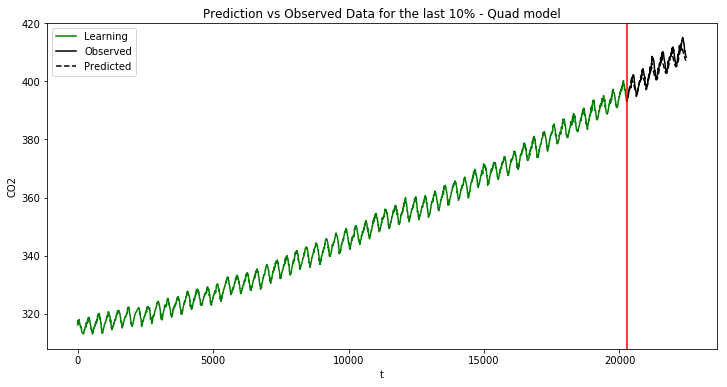

In [439]:
#Plot predicted data - test models

prediction_inner = inner_samples['future_x']
prediction_quad = quad_samples['future_x']
prediction_example = example_samples['future_x']

# Compute mean and 95% interval of the predicted values
prediction_mean_inner = np.mean(prediction_inner, axis=0)
prediction_mean_quad = np.mean(prediction_quad, axis=0)
prediction_mean_example = np.mean(prediction_example, axis=0)

prediction_interval_inner = np.percentile(prediction_inner, axis=0, q=[2.5, 97.5])
prediction_interval_quad = np.percentile(prediction_quad, axis=0, q=[2.5, 97.5])
prediction_interval_example = np.percentile(prediction_example, axis=0, q=[2.5, 97.5])

# Plotting

plt.figure(figsize=(12, 6))
plt.plot(t[:n], y[:n], 'g-', label='Learning')
plt.plot(t[n:], y[n:], 'k-', label='Observed')

# means
#plt.plot(t[n:], prediction_mean_example, 'k--', label='Predicted')
plt.plot(t[n:], prediction_mean_quad, 'k--', label='Predicted')
#plt.plot(t[n:], prediction_mean_inner, 'k--', label='Predicted')

# 95% intervals
#plt.plot(t[n:],prediction_interval[0,:],'b-', label='prediction 95% interval')
#plt.plot(t[n:],prediction_interval[1,:],'b-', label='prediction 95% interval')

# prediction with the example model - the line of co+t*c1
#line_y = t*np.mean(example_samples['c1']) + np.mean(example_samples['c0'])
#plt.plot(t,line_y,'.-', label='line of best fit', color='red')

plt.axvline(t[n], color='red')
plt.xlabel('t')
plt.ylabel('CO2')
plt.legend()
plt.title('Prediction vs Observed Data for the last 10% - Quad model')
plt.show()

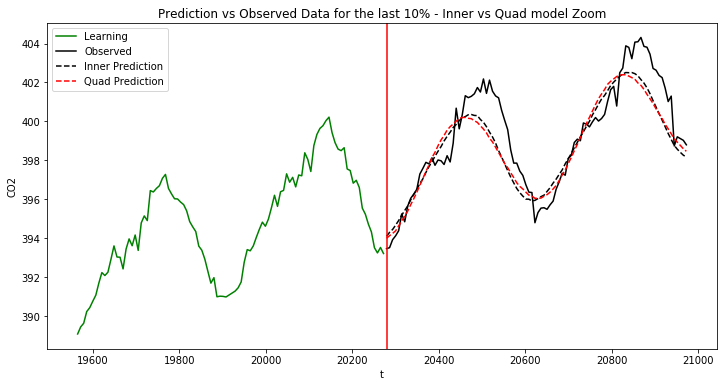

In [434]:
# Zoom-in plots

zoom = 100 #zoom around t

plt.figure(figsize=(12, 6))
plt.plot(t[n-zoom:n], y[n-zoom:n], 'g-', label='Learning')
plt.plot(t[n:n+zoom], y[n:n+zoom], 'k-', label='Observed')
plt.plot(t[n:n+zoom], prediction_mean_inner[:zoom], 'k--', label='Inner Prediction')
plt.plot(t[n:n+zoom], prediction_mean_quad[:zoom], 'r--', label='Quad Prediction')

#plt.plot(t[n:n+zoom],prediction_interval[0][:zoom],'b-', label='prediction 95% interval')
#plt.plot(t[n:n+zoom],prediction_interval[1][:zoom],'b-', label='prediction 95% interval')

plt.axvline(t[n], color='red')
plt.xlabel('t')
plt.ylabel('CO2')
plt.legend()
plt.title('Prediction vs Observed Data for the last 10% - Inner vs Quad model Zoom')
plt.show()

In [440]:
# Compute out of sample MSE for the data not used for training

def mse(prediction,test_data):
    return (np.mean(np.sqrt((prediction - test_data)**2)))
print('MSE using the means of all 4000 predictions:')
print('Example MSE: ', mse(prediction_mean_example,y[n:]) )
print('Quad MSE: ', mse(prediction_mean_quad,y[n:]))
print('Inner MSE: ', mse(prediction_mean_inner,y[n:]) )


print('\nMSE Over all predictions:')
print('Example MSE: ', mse(prediction_example,y[n:]))
print('Quad MSE: ', mse(prediction_quad,y[n:]))
print('Inner MSE: ', mse(prediction_inner,y[n:]))

MSE using the means of all 4000 predictions:
Example MSE:  9.591596892261187
Quad MSE:  1.484332332324043
Inner MSE:  1.4662498777721213

MSE Over all predictions:
Example MSE:  9.602792360525736
Quad MSE:  1.7997840259943567
Inner MSE:  1.7673930983111152


# 40 Year Prediction - Inner Model

In [444]:
# Produce and print Stan results
future_t = np.arange(t[-1]+7,t[-1]+365*40,7) #for the real prediction for the assignment

stan_data = {
    'n': len(y),
    'y': y,
    't': t,
    'future_t': future_t, 
    'future_n': len(future_t)} 

parameters = ['c0', 'c1', 'c2', 'c3', 'c4', 'quad', 'inner']

results = stan_model_inner.sampling(data=stan_data, iter=4000, warmup=3000)
print(results.stansummary(pars=parameters))
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_66dfc2962fb0600241ac28e7c5e1d6c5.
4 chains, each with iter=4000; warmup=3000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    314.58  1.7e-3   0.07 314.44 314.53 314.58 314.62 314.71   1670    1.0
c1    2.1e-3  3.7e-7 1.4e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   1462    1.0
c2      2.69  5.9e-4   0.03   2.62   2.66   2.69   2.71   2.75   3116    1.0
c3    7.0e-4  7.4e-6 4.6e-4 1.2e-4 3.7e-4 6.1e-4 9.3e-4 1.8e-3   3809    1.0
c4      1.26  2.9e-4   0.02   1.22   1.25   1.26   1.27   1.29   3027    1.0
quad  9.7e-8 1.5e-116.0e-10 9.6e-8 9.7e-8 9.7e-8 9.8e-8 9.8e-8   1572    1.0
inner  -0.27  3.8e-4   0.02  -0.31  -0.28  -0.27  -0.25  -0.22   3349    1.0

Samples were drawn using NUTS at Fri Dec 20 18:09:23 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

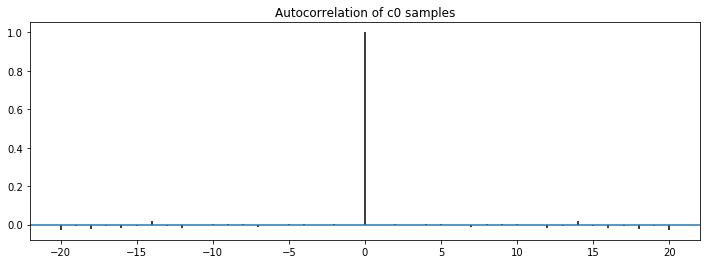

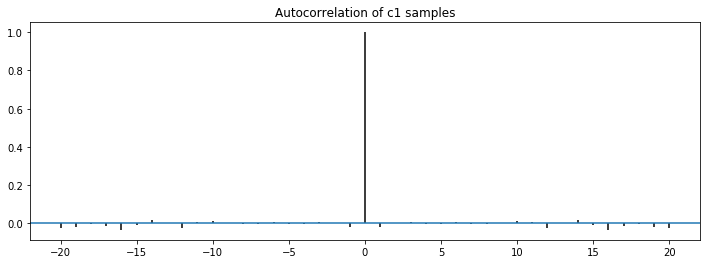

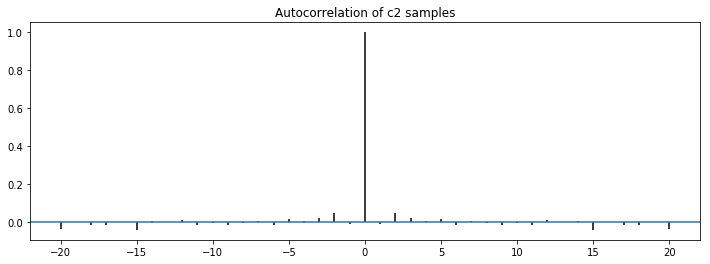

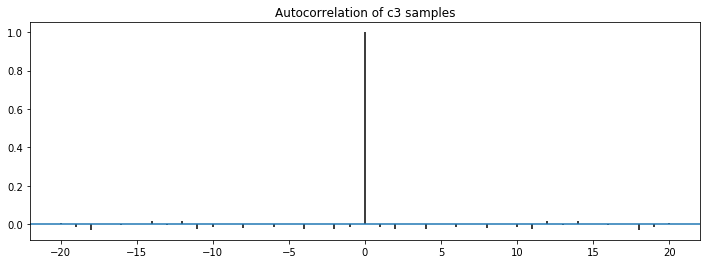

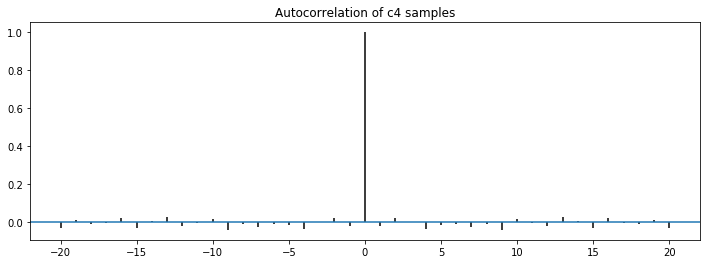

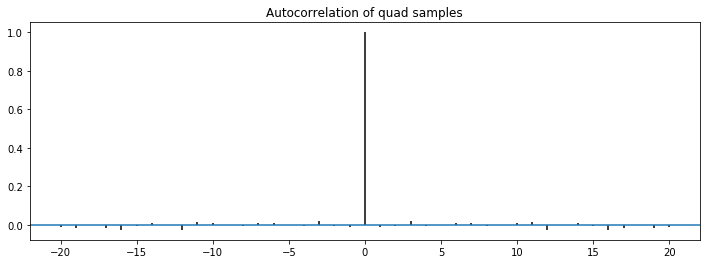

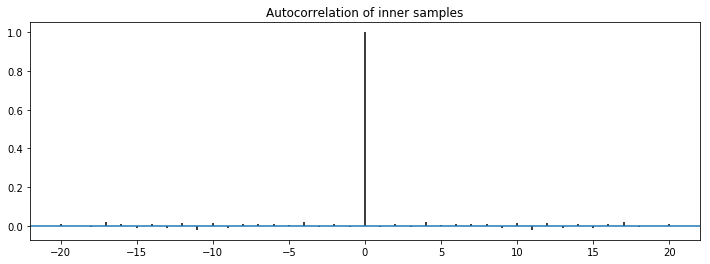

In [445]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

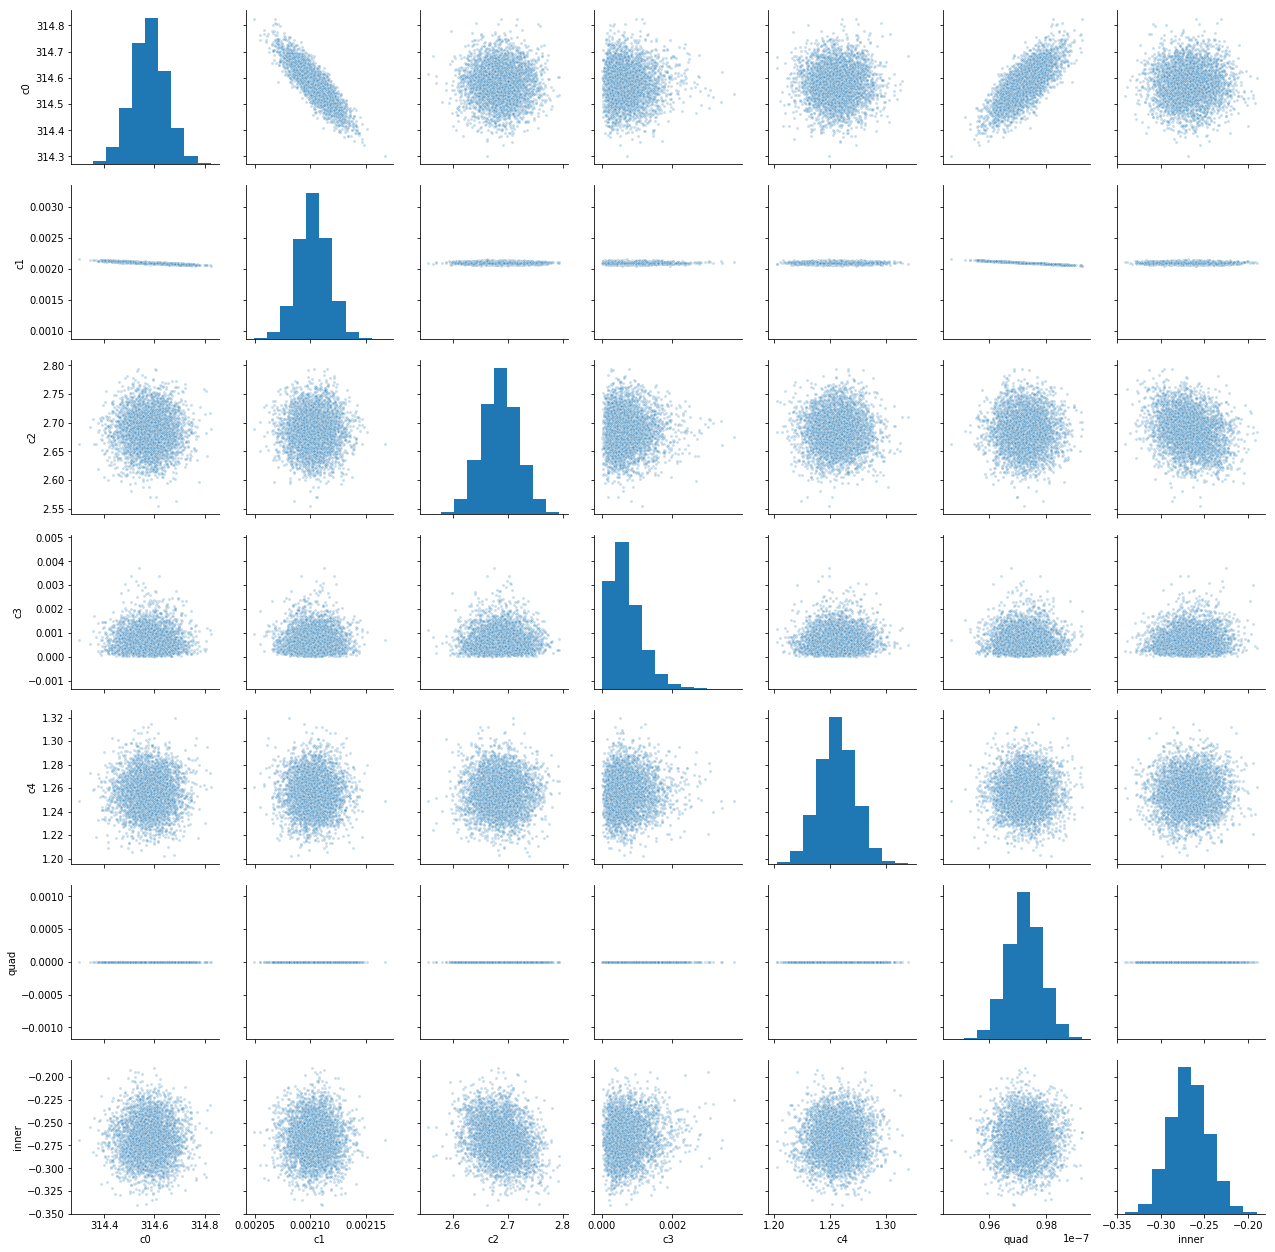

In [446]:
# Pair plots

df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [447]:
#run the diagnostics because it did not do so automatically
pystan.check_hmc_diagnostics(results)

{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': True}

In [219]:
# Create a function to convert back from 't' in days to dates for the graphs

from datetime import timedelta

def days_to_date(days):
    d = data['Date'][0]
    dates = []
    for i in range(len(days)):
        new_date = datetime.strptime(d, "%m/%d/%Y") + timedelta(int(days[i]))
        dates.append(new_date.strftime("%m/%d/%Y"))
    return (dates)

In [448]:
# Produce estimates for the questions

print('Best CO2 PPM estimate for %s: %.3f' %( days_to_date(future_t)[1996], prediction_mean[1996]))
print('CI:', prediction_interval[0][1996],prediction_interval[1][1996])

Best CO2 PPM estimate for 01/05/2058: 520.630
CI: 518.0930911052063 523.1978327891796


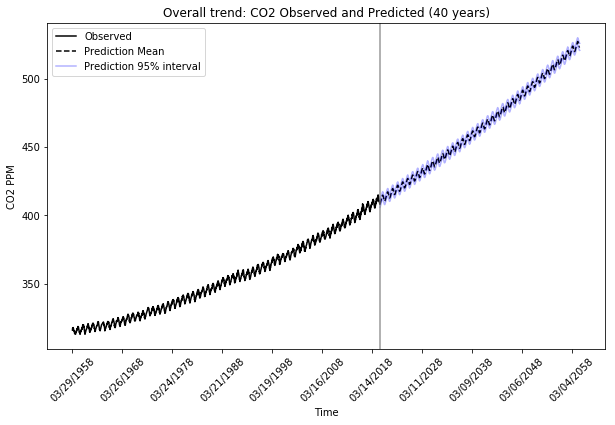

In [449]:
#Plot Overall Trend of Predictionsn

prediction = samples['future_x']

# Compute mean and 95% interval of the predicted values
prediction_mean = np.mean(prediction, axis=0)
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(10, 6))
plt.plot(t, y, 'k-', label='Observed')
plt.plot(future_t, prediction_mean, 'k--', label='Prediction Mean')
plt.plot(future_t,prediction_interval[0,:],'b-', alpha=0.3,label='Prediction 95% interval')
plt.plot(future_t,prediction_interval[1,:],'b-', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('CO2 PPM')
ticks = np.arange(0,future_t[-1],365*10)
labels = days_to_date(ticks)
plt.xticks(ticks, labels,rotation=45)
plt.axvline(t[-1], color='grey',alpha=0.8)
plt.legend()
plt.title('Overall trend: CO2 Observed and Predicted (40 years)')
plt.show()

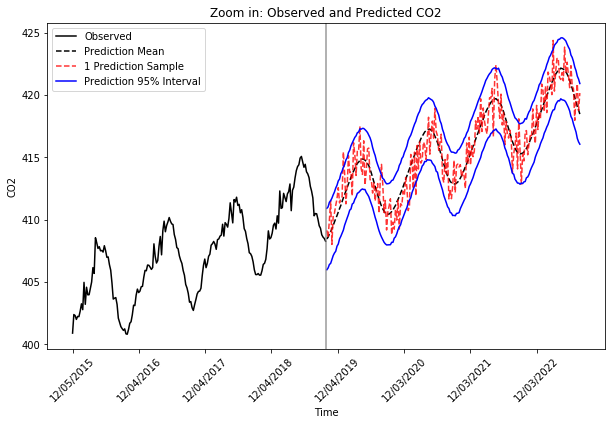

In [450]:
#Plot zoom-in to see the prediction in detail

zoom = 200 #zoom around t
plt.figure(figsize=(10, 6))
plt.plot(t[len(t)-zoom:], y[len(t)-zoom:], 'k-', label='Observed')
plt.plot(future_t[:zoom], prediction_mean[:zoom], 'k--', label='Prediction Mean')
plt.plot(future_t[:zoom], prediction[0][:zoom], 'r--', alpha=0.8, label='1 Prediction Sample')
plt.plot(future_t[:zoom],prediction_interval[0][:zoom],'b-', label='Prediction 95% Interval')
plt.plot(future_t[:zoom],prediction_interval[1][:zoom],'b-')                          
plt.xlabel('Time')
plt.ylabel('CO2')
ticks = np.arange(t[len(t)-zoom],future_t[zoom],365)
labels = days_to_date(ticks)
plt.xticks(ticks, labels,rotation=45)
plt.axvline(t[-1], color='grey',alpha=0.8)
plt.legend()
plt.title('Zoom in: Observed and Predicted CO2')
plt.show()

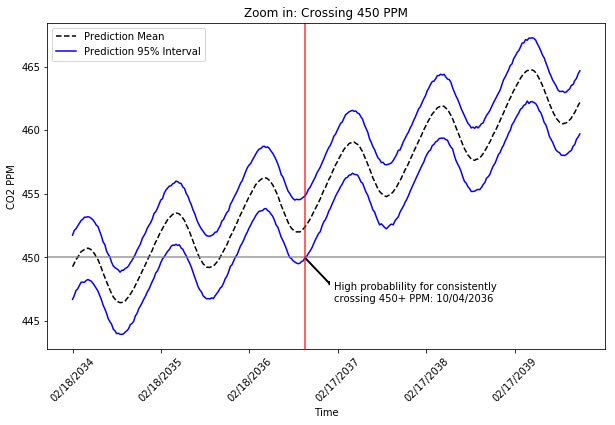

In [451]:
#plot arriving at 450 ppm

a = 750 #start and end points
b = 1050

plt.figure(figsize=(10, 6))
plt.plot(future_t[a:b], prediction_mean[a:b], 'k--', label='Prediction Mean')
plt.plot(future_t[a:b],prediction_interval[0][a:b],'b-', label='Prediction 95% Interval')
plt.plot(future_t[a:b],prediction_interval[1][a:b],'b-')                          
plt.xlabel('Time')
plt.ylabel('CO2 PPM')
ticks = np.arange(future_t[a],future_t[b],365)
labels = days_to_date(ticks)
plt.xticks(ticks, labels,rotation=45)
plt.axhline(450, color='grey',alpha=0.8)
plt.axvline(future_t[887], color='red',alpha=0.8)
plt.arrow(future_t[887], prediction_interval[0][887], 100, -2, width=0.1)
plt.text(future_t[887]+120,prediction_interval[0][887]-2.5, 'High probablility for consistently')
plt.text(future_t[887]+120,prediction_interval[0][887]-3.5, 'crossing 450+ PPM: '+days_to_date([future_t[887]])[0])

plt.legend()
plt.title('Zoom in: Crossing 450 PPM')
plt.show()